<a href="https://colab.research.google.com/github/tyceaddley/User-Classification/blob/main/UserFlywheelAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Clustering User Generated Sessions for Quality Assessment

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

import hdbscan
from sklearn.metrics import pairwise_distances_argmin_min

from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import parallel_coordinates
from sklearn.utils import check_random_state
from google.cloud import bigquery

In [2]:
SEED = 99
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
rng = check_random_state(SEED)

#Clustering With Category Counts with K-Means

In [3]:
raw_import = pd.read_csv('raw_data_file.csv')

In [4]:
ct_df = raw_import.copy()

After importing the session metrics data the Clicks, Platform, and Device_Category are removed. Clicks has a high correlation with Detail Pageviews and business logic dictates that Detail Pageviews are a more important metric to evaluate.

In [5]:
ct_df = ct_df.drop(columns=['Clicks','Platform','Device_Category'])

Evaluating the maximum values for a single session. There are large outliers with value counts high above what the average session, or even high performing session will generate.

In [6]:
ct_df.max()

,0
Date,2025-04-30
user_pseudo_id,ffffd6bc8b2728a73c660e382cc15912
KSL_Member_Id,7659647
DDM_Session_Id,ffffd6bc8b2728a73c660e382cc1591217448090092025...
Impressions,48788
Pageviews,2459
DetailPageviews,848
Favorites,1646
Shares,119
Leads,500


In [7]:
ct_df.describe()

,KSL_Member_Id,Impressions,Pageviews,DetailPageviews,Favorites,Shares,Leads,Categories,SubCategories
count,4.843465e+06,4.843465e+06,4.843465e+06,4.843465e+06,4.843465e+06,4.843465e+06,4.843465e+06,4.843465e+06,4.843465e+06
mean,2.533159e+06,2.122765e+02,1.420325e+01,3.177831e+00,2.584982e-01,3.194283e-02,9.795859e-02,4.917226e+00,1.268170e+01
std,1.666296e+06,5.953125e+02,2.652291e+01,8.148603e+00,1.746440e+00,3.043416e-01,6.746758e-01,5.827485e+00,2.145633e+01
min,1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.500460e+05,1.400000e+01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
50%,2.578228e+06,5.600000e+01,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,4.000000e+00
75%,3.948975e+06,1.880000e+02,1.500000e+01,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,1.400000e+01
max,7.659647e+06,4.878800e+04,2.459000e+03,8.480000e+02,1.646000e+03,1.190000e+02,5.000000e+02,5.600000e+01,4.270000e+02


In [8]:
ct_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843465 entries, 0 to 4843464
Data columns (total 12 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   Date             object
 1   user_pseudo_id   object
 2   KSL_Member_Id    int64 
 3   DDM_Session_Id   object
 4   Impressions      int64 
 5   Pageviews        int64 
 6   DetailPageviews  int64 
 7   Favorites        int64 
 8   Shares           int64 
 9   Leads            int64 
 10  Categories       int64 
 11  SubCategories    int64 
dtypes: int64(9), object(3)
memory usage: 443.4+ MB


KSL_Member_Id is a numberical ID field and needs to be treated as an object and not a numerical value type.

In [9]:
ct_df.astype({'KSL_Member_Id':'object'}).dtypes

,0
Date,object
user_pseudo_id,object
KSL_Member_Id,object
DDM_Session_Id,object
Impressions,int64
Pageviews,int64
DetailPageviews,int64
Favorites,int64
Shares,int64
Leads,int64


In [10]:
features = [
              'Impressions'
            , 'Pageviews'
            , 'DetailPageviews'
            , 'Favorites'
            , 'Shares'
            , 'Leads'
            , 'Categories'
            , 'SubCategories'
            ]
filter_features = [
              'Impressions'
            , 'Pageviews'
            , 'DetailPageviews'
            , 'Favorites'
            , 'Shares'
            , 'Leads'
            , 'Categories'
            , 'SubCategories'
            ]
wieghted_features = [
              'Impressions_weighted'
            , 'Pageviews_weighted'
            , 'DetailPageviews_weighted'
            , 'Favorites_weighted'
            , 'Shares_weighted'
            , 'Leads_weighted'
            , 'Categories_weighted'
            , 'SubCategories_weighted'
            ]

After reviewing the maximum values and other distribution characteristics to identify outliers, I will be trimming the top 0.01% of sessions. Based on the business logic of how the site operates, it is highly unlikely that these extreme sessions reflect legitimate user behavior. They are more plausibly attributable to fraud or measurement error within Google Analytics.

In [11]:
mask = pd.Series(True, index=ct_df.index)

for feature in filter_features:
    lower, upper = ct_df[feature].quantile([0.00, 0.999])
    mask &= ct_df[feature].between(lower, upper)

ct_df = ct_df[mask].copy()

X = ct_df[features]

In [12]:
ct_df.max()

,0
Date,2025-04-30
user_pseudo_id,ffffd6bc8b2728a73c660e382cc15912
KSL_Member_Id,7659647
DDM_Session_Id,ffffd6bc8b2728a73c660e382cc1591217448090092025...
Impressions,7263
Pageviews,278
DetailPageviews,91
Favorites,17
Shares,4
Leads,6


In [13]:
scaler = RobustScaler()
X = scaler.fit_transform(ct_df[features])

In [14]:
sessions = ct_df.copy()

In [15]:
pca = PCA(n_components=6, random_state=99)
X_pca = pca.fit_transform(X)

In [16]:
inertia = []
k_range = range(2,10)

In [ ]:
for k in k_range:
  km = KMeans(n_clusters=k, n_init=10, random_state=99)
  km.fit(X_pca)
  inertia.append(km.inertia_)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method: Optimal Cluster Count")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
sil_scores = []
X_sample = resample(X_pca, n_samples=200000, random_state=99)

k_range = range(2,10)

best_score = -1
best_k = None

In [ ]:
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=99)
    labels = kmeans.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    sil_scores.append(score)

    if score > best_score:
        best_score = score
        best_k = k

print(f"Best silhouette score: {best_score:.3f} at k = {best_k}")

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(k_range, sil_scores, marker='s')
plt.title("Silhouette Score by Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
kmeans = KMeans(n_clusters=6, random_state=99, n_init='auto')
sessions['cluster'] = kmeans.fit_predict(X_pca)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


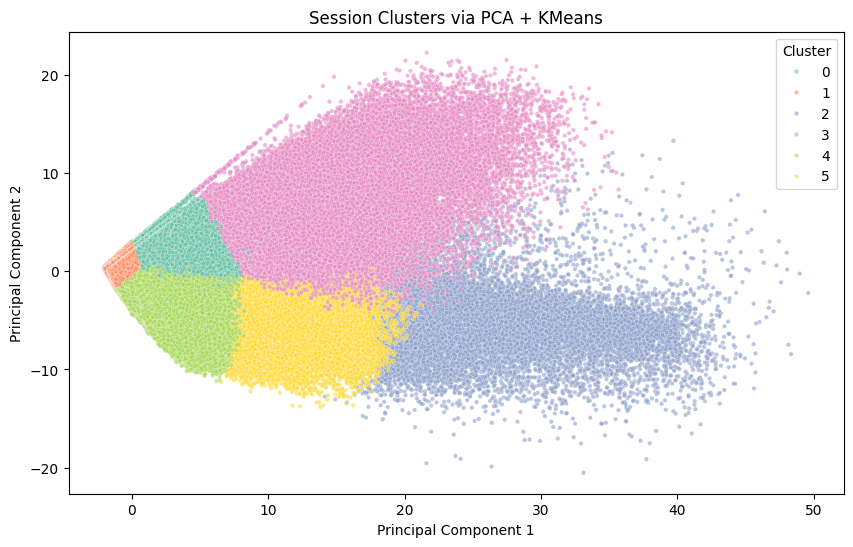

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=sessions['cluster'], palette='Set2', s=10, alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Session Clusters via PCA + KMeans')
plt.legend(title='Cluster')
plt.show()

In [21]:
explained_variance = pca.explained_variance_
total_explained_variance = explained_variance.sum()

explained_variance_ratio = pca.explained_variance_ratio_
total_explained_variance_ratio = explained_variance_ratio.sum()

print(f"Explained Variance:\n{explained_variance}")
print(f"Total Explained Variance: {total_explained_variance}")

print(f"\nExplained Variance Ratio:\n{explained_variance_ratio}")
print(f"Total Explained Variance Ratio: {total_explained_variance_ratio:.4f}")

Explained Variance:
[11.74569819  3.16784233  2.22531011  0.73990308  0.53047902  0.15136534]
Total Explained Variance: 18.560598073481497

Explained Variance Ratio:
[0.62785669 0.16933442 0.11895213 0.03955091 0.02835632 0.00809111]
Total Explained Variance Ratio: 0.9921


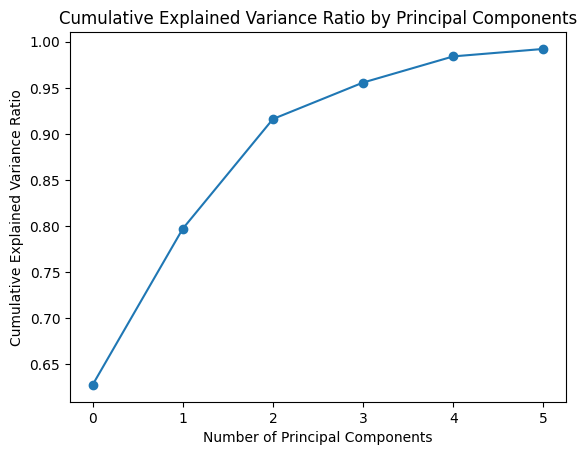

In [22]:
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Principal Components')
plt.show()

In [23]:
cluster_profiles = sessions.groupby('cluster')[features].mean().round(3)

cluster_sizes = sessions.groupby('cluster').size().rename('Count')

summary = cluster_profiles.join(cluster_sizes)

summary_sorted = summary.sort_values(
    by=['Impressions', 'Pageviews'], ascending=False
).reset_index()

print("Sorted Average User Metrics per Cluster (with Counts):\n")
print(tabulate(summary_sorted, headers='keys', tablefmt='fancy_grid'))

Sorted Average User Metrics per Cluster (with Counts):

╒════╤═══════════╤═══════════════╤═════════════╤═══════════════════╤═════════════╤══════════╤═════════╤══════════════╤═════════════════╤══════════════════╕
│    │   cluster │   Impressions │   Pageviews │   DetailPageviews │   Favorites │   Shares │   Leads │   Categories │   SubCategories │            Count │
╞════╪═══════════╪═══════════════╪═════════════╪═══════════════════╪═════════════╪══════════╪═════════╪══════════════╪═════════════════╪══════════════════╡
│  0 │         2 │      4113.93  │     101.204 │            23.792 │       1.994 │    0.164 │   0.605 │       11.583 │          43.197 │  27869           │
├────┼───────────┼───────────────┼─────────────┼───────────────────┼─────────────┼──────────┼─────────┼──────────────┼─────────────────┼──────────────────┤
│  1 │         5 │      1542.13  │      50.972 │             9.817 │       0.702 │    0.074 │   0.291 │       12.991 │          47.515 │ 132636           │
├────┼──

In [24]:
session_quality_labels = {
    1: 'Very Low Quality',
    0: 'Low Quality',
    3: 'Medium-High Quality',
    5: 'Medium Quality',
    4: 'High Quality',
    2: 'Low-Medium Quality'
}

sessions['session_quality_label'] = sessions['cluster'].map(session_quality_labels)

In [25]:
cluster_profiles = sessions.groupby('session_quality_label')[features].mean().round(3)

cluster_sizes = sessions.groupby('session_quality_label').size().rename('Count')

summary = cluster_profiles.join(cluster_sizes)

summary_sorted = summary.sort_values(
    by=['Impressions', 'Pageviews'], ascending=False
).reset_index()

print("Sorted Average User Metrics per Cluster (with Counts):\n")
print(tabulate(summary_sorted, headers='keys', tablefmt='fancy_grid'))

Sorted Average User Metrics per Cluster (with Counts):

╒════╤═════════════════════════╤═══════════════╤═════════════╤═══════════════════╤═════════════╤══════════╤═════════╤══════════════╤═════════════════╤═════════╕
│    │ session_quality_label   │   Impressions │   Pageviews │   DetailPageviews │   Favorites │   Shares │   Leads │   Categories │   SubCategories │   Count │
╞════╪═════════════════════════╪═══════════════╪═════════════╪═══════════════════╪═════════════╪══════════╪═════════╪══════════════╪═════════════════╪═════════╡
│  0 │ Low-Medium Quality      │      4113.93  │     101.204 │            23.792 │       1.994 │    0.164 │   0.605 │       11.583 │          43.197 │   27869 │
├────┼─────────────────────────┼───────────────┼─────────────┼───────────────────┼─────────────┼──────────┼─────────┼──────────────┼─────────────────┼─────────┤
│  1 │ Medium Quality          │      1542.13  │      50.972 │             9.817 │       0.702 │    0.074 │   0.291 │       12.991 │       

In [26]:
cluster_centroids = cluster_profiles[[
    'Impressions', 'Pageviews', 'DetailPageviews',
    'Categories', 'SubCategories'
    ]]
# cluster_centroids.head(6)

In [27]:
low_quality_mask = sessions['session_quality_label'].isin(['Very Low Quality','Low Quality'])

engaged_mask = sessions[['Leads','Favorites','Shares']].sum(axis=1) > 0

upgrade_mask = low_quality_mask & engaged_mask
sessions_to_upgrade = sessions[upgrade_mask].copy()

quality_order = ['Very Low Quality', 'Low Quality', 'Low-Medium Quality', 'Medium Quality', 'Medium-High Quality', 'High Quality']
quality_rank = {label: i for i, label in enumerate(quality_order)}
sessions['quality_rank'] = sessions['session_quality_label'].map(quality_rank)

valid_clusters = sessions[sessions['quality_rank'] >= quality_rank['Low-Medium Quality']]['cluster'].unique()
valid_cluster_centroids = sessions[sessions['cluster'].isin(valid_clusters)].groupby('cluster')[['Impressions', 'Pageviews', 'DetailPageviews', 'Favorites', 'Shares', 'Leads', 'Categories', 'SubCategories']].mean()

X_upgrade = sessions_to_upgrade[['Impressions', 'Pageviews', 'DetailPageviews', 'Favorites', 'Shares', 'Leads', 'Categories', 'SubCategories']]
closest_centroid_idx, _ = pairwise_distances_argmin_min(X_upgrade.values, valid_cluster_centroids.values)

new_cluster_ids = valid_cluster_centroids.index[closest_centroid_idx].values
sessions_to_upgrade['new_cluster'] = new_cluster_ids

sessions.loc[sessions_to_upgrade.index, 'cluster'] = sessions_to_upgrade['new_cluster']

changed = sessions.loc[sessions_to_upgrade.index]
print("Sample of sessions reassigned to better clusters based on engagement:\n")
print(changed[['session_quality_label', 'cluster', 'Leads', 'Favorites', 'Shares']].head(10))

pre_change_counts = sessions['session_quality_label'].value_counts().sort_index()

updated_labels = sessions['cluster'].map(session_quality_labels)  # assume you have this dict
sessions['session_quality_label'] = updated_labels

post_change_counts = sessions['session_quality_label'].value_counts().sort_index()

compare_df = pd.DataFrame({
    'Before': pre_change_counts,
    'After': post_change_counts
}).fillna(0).astype(int)

Sample of sessions reassigned to better clusters based on engagement:

    session_quality_label  cluster  Leads  Favorites  Shares
76       Very Low Quality        4      0          1       0
78       Very Low Quality        4      1          0       0
340      Very Low Quality        4      1          0       0
433      Very Low Quality        4      0          1       0
477      Very Low Quality        4      0          1       0
550      Very Low Quality        4      0          2       0
569      Very Low Quality        4      1          0       0
576      Very Low Quality        4      1          0       1
601      Very Low Quality        4      0          0       1
758      Very Low Quality        4      0          1       0


In [28]:
compare_df = pd.DataFrame({
    'Before': pre_change_counts,
    'After': sessions['session_quality_label'].value_counts().sort_index()
}).fillna(0).astype(int)

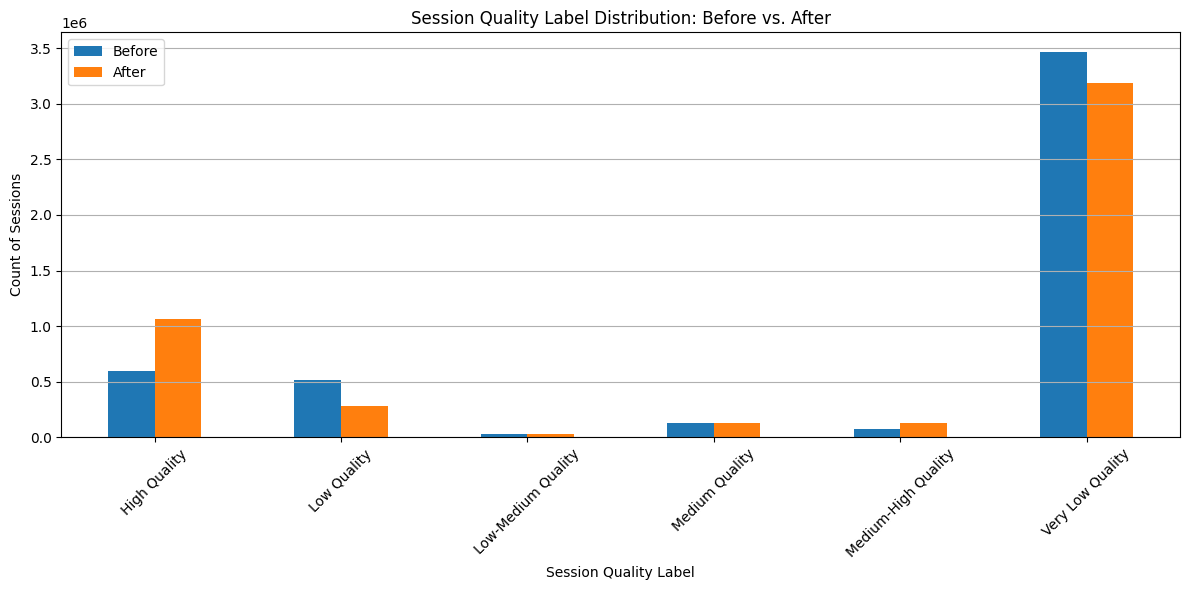

In [29]:
# Step 5: Plot
ax = compare_df.plot(kind='bar', figsize=(12, 6))
plt.title("Session Quality Label Distribution: Before vs. After")
plt.xlabel("Session Quality Label")
plt.ylabel("Count of Sessions")
plt.xticks(rotation=45)
plt.grid(axis='y')

# Step 4: Add numerical labels on bars
# for i, bar_group in enumerate(ax.containers):
#     for bar in bar_group:
#         height = bar.get_height()
#         ax.annotate(f'{int(height)}',
#                     xy=(bar.get_x() + bar.get_width() / 2, height),
#                     xytext=(0, 3),  # offset text above bar
#                     textcoords="offset points",
#                     ha='center', va='bottom', fontsize=9, rotation=0)

plt.tight_layout()
plt.show()

In [30]:
sessions.groupby('session_quality_label')['Leads'].describe()

,count,mean,std,min,25%,50%,75%,max
session_quality_label,,,,,,,,
High Quality,1066174.0,0.266067,0.635211,0.0,0.0,0.0,0.0,6.0
Low Quality,279266.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Low-Medium Quality,27869.0,0.605440,1.123164,0.0,0.0,0.0,1.0,6.0
Medium Quality,132643.0,0.290562,0.743099,0.0,0.0,0.0,0.0,6.0
Medium-High Quality,124298.0,0.592335,1.105695,0.0,0.0,0.0,1.0,6.0
Very Low Quality,3186909.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [31]:
sessions_to_upgrade_deduped = sessions_to_upgrade.drop_duplicates(subset='DDM_Session_Id')
sessions_deduped = sessions.drop_duplicates(subset='DDM_Session_Id')

sessions_deduped.set_index('DDM_Session_Id', inplace=True)
sessions_to_upgrade_deduped.set_index('DDM_Session_Id', inplace=True)

sessions_deduped.update(sessions_to_upgrade_deduped)

sessions_deduped.reset_index(inplace=True)

/tmp/ipython-input-31-3811990353.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 1 1 1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  sessions_deduped.update(sessions_to_upgrade_deduped)


In [32]:
print(sessions.shape)

(4817159, 15)


In [33]:
user_cluster_counts = sessions.groupby(['KSL_Member_Id', 'session_quality_label']).size().unstack(fill_value=0)

user_cluster_ratios = user_cluster_counts.div(user_cluster_counts.sum(axis=1), axis=0).fillna(0).round(3)

/tmp/ipython-input-34-899130451.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=session_type_totals.index, y=session_type_totals.values, palette='Set2')


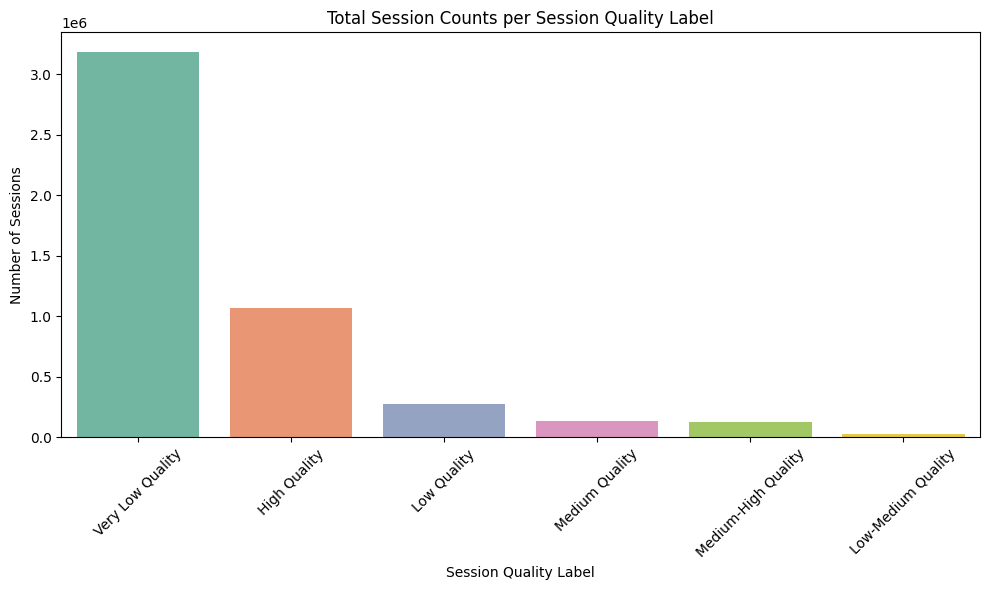

In [34]:
session_type_totals = user_cluster_counts.sum().sort_values(ascending=False)

# Plot histogram
plt.figure(figsize=(10, 6))
sns.barplot(x=session_type_totals.index, y=session_type_totals.values, palette='Set2')
plt.title("Total Session Counts per Session Quality Label")
plt.xlabel("Session Quality Label")
plt.ylabel("Number of Sessions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
# user_features = pd.concat([user_cluster_counts.add_prefix('count_'), user_cluster_ratios.add_prefix('ratio_')],axis=1)
user_features = pd.concat([user_cluster_ratios.add_prefix('ratio_')],axis=1)
# user_features = pd.concat([user_cluster_counts.add_prefix('count_')],axis=1)

In [36]:
print(user_cluster_counts.shape)

(382460, 6)


In [37]:
user_featured_scaled = scaler.fit_transform(user_features)

In [38]:
pca = PCA(n_components=3, random_state=99)
User_PCA = pca.fit_transform(user_featured_scaled)

In [39]:
kmeans_users = KMeans(n_clusters=5, n_init=10, random_state=99)
user_features['user_cluster'] = kmeans_users.fit_predict(User_PCA)

In [40]:
user_features[['pca1','pca2','pca3']] = User_PCA

In [41]:
explained_variance = pca.explained_variance_
total_explained_variance = explained_variance.sum()

explained_variance_ratio = pca.explained_variance_ratio_
total_explained_variance_ratio = explained_variance_ratio.sum()

print(f"Explained Variance:\n{explained_variance}")
print(f"Total Explained Variance: {total_explained_variance}")

print(f"\nExplained Variance Ratio:\n{explained_variance_ratio}")
print(f"Total Explained Variance Ratio: {total_explained_variance_ratio:.4f}")

Explained Variance:
[30.17778843  0.80540363  0.03665314]
Total Explained Variance: 31.01984519349608

Explained Variance Ratio:
[0.97258084 0.02595684 0.00118127]
Total Explained Variance Ratio: 0.9997


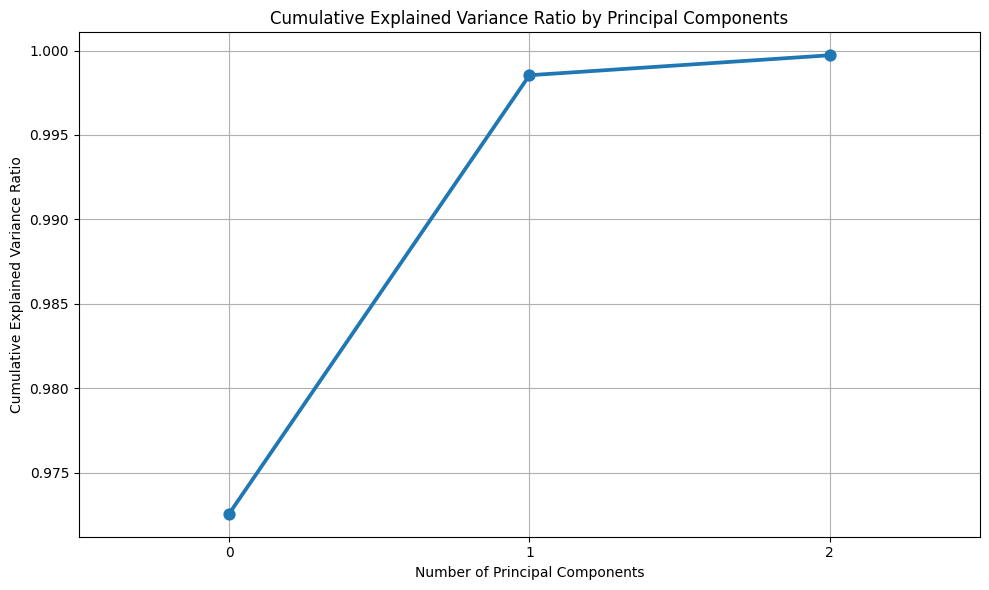

In [42]:
plt.figure(figsize=(10, 6))
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
sns.pointplot(cumulative_variance_ratio, marker='o')
plt.title('Cumulative Explained Variance Ratio by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

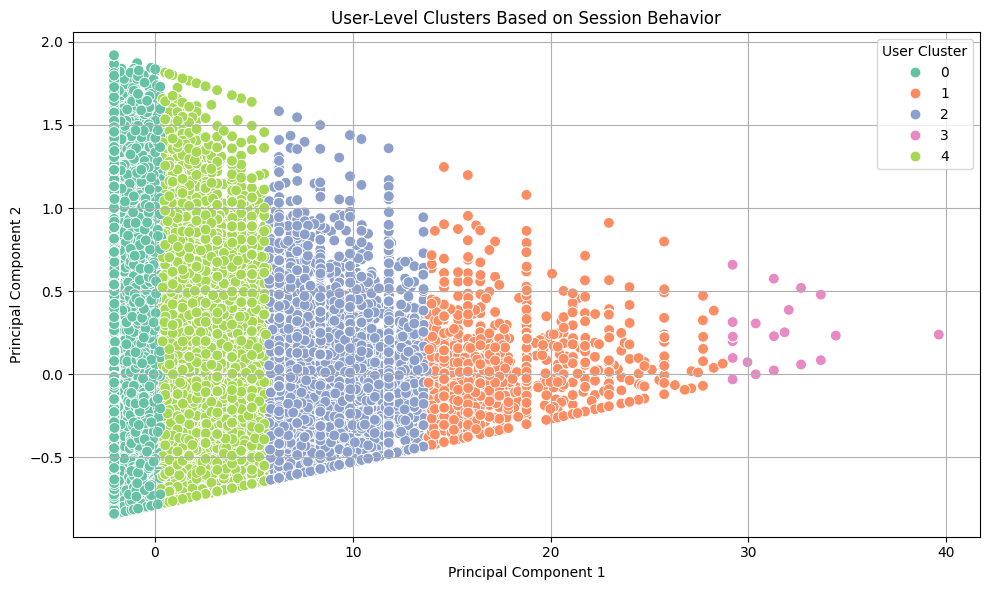

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_features, x='pca1', y='pca2', hue='user_cluster', palette='Set2', s=60)
plt.title("User-Level Clusters Based on Session Behavior")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="User Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
user_counts = user_features.groupby('user_cluster').size().rename('UserCount')

cluster_summary = (
    user_features
    .groupby('user_cluster')
    .mean()
    .round(2)
    .reset_index()
)

cluster_summary_with_counts = cluster_summary.merge(user_counts, on='user_cluster')

print("Average Session Cluster Mix Per User Cluster (with User Counts):\n")
print(tabulate(cluster_summary_with_counts, headers='keys', tablefmt='fancy_grid'))


Average Session Cluster Mix Per User Cluster (with User Counts):

╒════╤════════════════╤══════════════════════╤═════════════════════╤════════════════════════════╤════════════════════════╤═════════════════════════════╤══════════════════════════╤════════╤════════╤════════╤═════════════╕
│    │   user_cluster │   ratio_High Quality │   ratio_Low Quality │   ratio_Low-Medium Quality │   ratio_Medium Quality │   ratio_Medium-High Quality │   ratio_Very Low Quality │   pca1 │   pca2 │   pca3 │   UserCount │
╞════╪════════════════╪══════════════════════╪═════════════════════╪════════════════════════════╪════════════════════════╪═════════════════════════════╪══════════════════════════╪════════╪════════╪════════╪═════════════╡
│  0 │              0 │                 0.29 │                0    │                       0    │                   0.02 │                        0.01 │                     0.66 │  -1.96 │   0.02 │   0.01 │      303287 │
├────┼────────────────┼──────────────────────┼────

In [45]:
user_cluster_labels = {
    1: 'Explorer',
    2: 'Regular',
    4: 'Champion',
    0: 'Beginner',
    3: 'Stranger'
}

user_features['user_flywheel_label'] = user_features['user_cluster'].map(user_cluster_labels)
user_features = user_features.drop(columns=['pca1','pca2','pca3'])

In [46]:
user_counts = user_features.groupby('user_flywheel_label').size().rename('UserCount')


cluster_summary = (
    user_features
    .groupby('user_flywheel_label')
    .mean()
    .round(2)
    .reset_index()
)

cluster_summary_with_counts = cluster_summary.merge(user_counts, on='user_flywheel_label')

print("Average Session Cluster Mix Per User Cluster (with User Counts):\n")
print(tabulate(cluster_summary_with_counts, headers='keys', tablefmt='fancy_grid'))

Average Session Cluster Mix Per User Cluster (with User Counts):

╒════╤═══════════════════════╤══════════════════════╤═════════════════════╤════════════════════════════╤════════════════════════╤═════════════════════════════╤══════════════════════════╤════════════════╤═════════════╕
│    │ user_flywheel_label   │   ratio_High Quality │   ratio_Low Quality │   ratio_Low-Medium Quality │   ratio_Medium Quality │   ratio_Medium-High Quality │   ratio_Very Low Quality │   user_cluster │   UserCount │
╞════╪═══════════════════════╪══════════════════════╪═════════════════════╪════════════════════════════╪════════════════════════╪═════════════════════════════╪══════════════════════════╪════════════════╪═════════════╡
│  0 │ Beginner              │                 0.29 │                0    │                       0    │                   0.02 │                        0.01 │                     0.66 │              0 │      303287 │
├────┼───────────────────────┼──────────────────────┼─────────

In [47]:
final_labeled_sessions = user_features[['user_cluster','user_flywheel_label']].merge(
    sessions[['Date','user_pseudo_id','KSL_Member_Id','DDM_Session_Id','Impressions','Pageviews','DetailPageviews','Favorites','Shares','Leads','Categories','SubCategories','cluster','session_quality_label']],
    on='KSL_Member_Id',
    how='left'
)

In [48]:
trimmed = final_labeled_sessions['DDM_Session_Id'].str[:-8]

final_labeled_sessions['timestamp_str'] = trimmed.str[-10:]

final_labeled_sessions['Unix_Timestamp'] = final_labeled_sessions['timestamp_str'].astype(int)

final_labeled_sessions['Session_UTC'] = pd.to_datetime(final_labeled_sessions['Unix_Timestamp'], unit='s', utc=True)

final_labeled_sessions['Session_MST'] = final_labeled_sessions['Session_UTC'].dt.tz_convert('America/Denver')

In [49]:
final_labeled_sessions.tail()

,KSL_Member_Id,user_cluster,user_flywheel_label,Date,user_pseudo_id,DDM_Session_Id,Impressions,Pageviews,DetailPageviews,Favorites,Shares,Leads,Categories,SubCategories,cluster,session_quality_label,timestamp_str,Unix_Timestamp,Session_UTC,Session_MST
4817154,7659632,0,Beginner,2025-04-30,eaceaca51e217ba987dbcdfa49d3a1e7,eaceaca51e217ba987dbcdfa49d3a1e717460718872025...,0,3,0,0,0,0,0,0,1,Very Low Quality,1746071887,1746071887,2025-05-01 03:58:07+00:00,2025-04-30 21:58:07-06:00
4817155,7659633,0,Beginner,2025-04-30,354379577.1746074132,354379577.1746074132174607413220250430,0,0,0,0,0,1,0,0,4,High Quality,1746074132,1746074132,2025-05-01 04:35:32+00:00,2025-04-30 22:35:32-06:00
4817156,7659635,0,Beginner,2025-04-30,1498726125.1746074101,1498726125.1746074101174607410120250430,182,5,0,0,0,0,20,64,4,High Quality,1746074101,1746074101,2025-05-01 04:35:01+00:00,2025-04-30 22:35:01-06:00
4817157,7659644,0,Beginner,2025-04-30,753265600.1746077480,753265600.1746077480174607748020250430,120,3,0,0,0,0,14,43,4,High Quality,1746077480,1746077480,2025-05-01 05:31:20+00:00,2025-04-30 23:31:20-06:00
4817158,7659647,0,Beginner,2025-04-30,AFA17E9EDD8E46279967CCD81F2EBCAE,AFA17E9EDD8E46279967CCD81F2EBCAE17460786402025...,0,0,0,0,0,2,0,0,4,High Quality,1746078640,1746078640,2025-05-01 05:50:40+00:00,2025-04-30 23:50:40-06:00


In [50]:
final_labeled_sessions.to_csv('labeled_sessions_and_users.csv')

In [52]:
final_labeled_sessions.to_parquet('labeled_sessions_april_2025')

#Train & Test for Nueral Network

In [3]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import pickle

In [4]:
raw_sessions = pd.read_parquet("/content/labeled_sessions_april_2025")

In [5]:
sessions = raw_sessions.copy()

In [6]:
sessions.head()

,KSL_Member_Id,user_cluster,user_flywheel_label,Date,user_pseudo_id,DDM_Session_Id,Impressions,Pageviews,DetailPageviews,Favorites,Shares,Leads,Categories,SubCategories,cluster,session_quality_label,timestamp_str,Unix_Timestamp,Session_UTC,Session_MST
0,14,0,Beginner,2025-04-02,c1e0402c8d65471b2b615f8159cca387,c1e0402c8d65471b2b615f8159cca38717436378202025...,76,8,7,0,0,1,1,4,4,High Quality,1743637820,1743637820,2025-04-02 23:50:20+00:00,2025-04-02 17:50:20-06:00
1,14,0,Beginner,2025-04-16,c1e0402c8d65471b2b615f8159cca387,c1e0402c8d65471b2b615f8159cca38717448493582025...,1200,131,40,2,0,0,21,89,3,Medium-High Quality,1744849358,1744849358,2025-04-17 00:22:38+00:00,2025-04-16 18:22:38-06:00
2,14,0,Beginner,2025-04-09,c1e0402c8d65471b2b615f8159cca387,c1e0402c8d65471b2b615f8159cca38717442640722025...,211,17,8,2,0,0,15,59,4,High Quality,1744264072,1744264072,2025-04-10 05:47:52+00:00,2025-04-09 23:47:52-06:00
3,14,0,Beginner,2025-04-08,c1e0402c8d65471b2b615f8159cca387,c1e0402c8d65471b2b615f8159cca38717441521382025...,211,24,20,3,0,0,11,28,4,High Quality,1744152138,1744152138,2025-04-08 22:42:18+00:00,2025-04-08 16:42:18-06:00
4,14,0,Beginner,2025-04-09,c1e0402c8d65471b2b615f8159cca387,c1e0402c8d65471b2b615f8159cca38717441836862025...,60,9,2,0,0,0,5,6,1,Very Low Quality,1744183686,1744183686,2025-04-09 07:28:06+00:00,2025-04-09 01:28:06-06:00


In [7]:
features = [
    'Impressions', 'Pageviews', 'DetailPageviews',
    'Favorites', 'Shares', 'Leads', 'Categories', 'SubCategories'
]
target = 'session_quality_label'

In [8]:
label_encoder = LabelEncoder()
sessions['label_encoded'] = label_encoder.fit_transform(sessions[target])

In [9]:
with open("label_encoder_sessions.pkl", "wb") as label_encoder_file:
    pickle.dump(label_encoder, label_encoder_file)

In [10]:
X = sessions[features]
y = sessions['label_encoded']
num_classes = y.nunique()

In [11]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
with open("minmax_scaler_sessions.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)

In [13]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=99, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=99, stratify=y_trainval)

In [14]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience=3,
    restore_best_weights=True
)

In [16]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64, callbacks=[early_stop])

Epoch 1/10
45161/45161 ━━━━━━━━━━━━━━━━━━━━ 165s 4ms/step - accuracy: 0.9783 - loss: 0.0664 - val_accuracy: 0.9962 - val_loss: 0.0102
Epoch 2/10
45161/45161 ━━━━━━━━━━━━━━━━━━━━ 195s 3ms/step - accuracy: 0.9946 - loss: 0.0129 - val_accuracy: 0.9960 - val_loss: 0.0096
Epoch 3/10
45161/45161 ━━━━━━━━━━━━━━━━━━━━ 170s 4ms/step - accuracy: 0.9954 - loss: 0.0112 - val_accuracy: 0.9959 - val_loss: 0.0087
Epoch 4/10
45161/45161 ━━━━━━━━━━━━━━━━━━━━ 181s 3ms/step - accuracy: 0.9959 - loss: 0.0099 - val_accuracy: 0.9973 - val_loss: 0.0072
Epoch 5/10
45161/45161 ━━━━━━━━━━━━━━━━━━━━ 203s 3ms/step - accuracy: 0.9962 - loss: 0.0092 - val_accuracy: 0.9975 - val_loss: 0.0066
Epoch 6/10
45161/45161 ━━━━━━━━━━━━━━━━━━━━ 210s 4ms/step - accuracy: 0.9964 - loss: 0.0085 - val_accuracy: 0.9964 - val_loss: 0.0086
Epoch 7/10
45161/45161 ━━━━━━━━━━━━━━━━━━━━ 196s 3ms/step - accuracy: 0.9967 - loss: 0.0080 - val_accuracy: 0.9973 - val_loss: 0.0065
Epoch 8/10
45161/45161 ━━━━━━━━━━━━━━━━━━━━ 152s 3ms/step - ac

In [17]:
model.save("session_quality_model.keras")

In [18]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

30108/30108 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - accuracy: 0.9976 - loss: 0.0054
Test Accuracy: 0.9976324439048767


In [19]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

30108/30108 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step


In [20]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:

                     precision    recall  f1-score   support

       High Quality       1.00      1.00      1.00    213235
        Low Quality       0.99      0.99      0.99     55853
 Low-Medium Quality       1.00      0.97      0.99      5574
     Medium Quality       0.99      0.97      0.98     26529
Medium-High Quality       0.98      0.98      0.98     24859
   Very Low Quality       1.00      1.00      1.00    637382

           accuracy                           1.00    963432
          macro avg       0.99      0.99      0.99    963432
       weighted avg       1.00      1.00      1.00    963432



In [21]:
conf_matrix = confusion_matrix(y_test, y_pred)

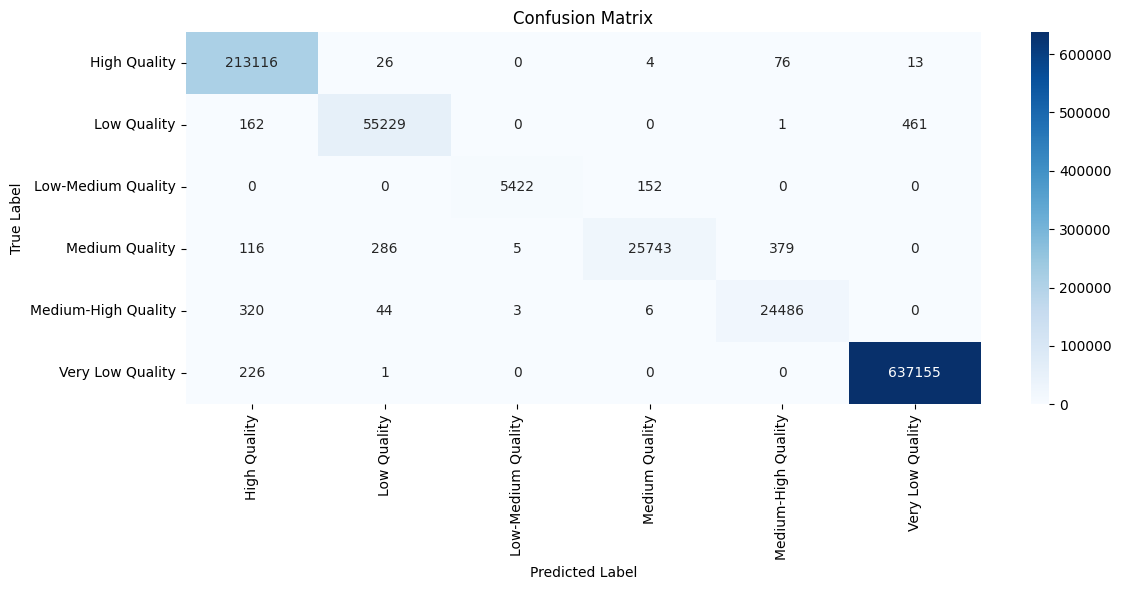

In [22]:
plt.figure(figsize=(12,6))
sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [23]:
user_cluster_counts = sessions.groupby(['KSL_Member_Id', 'session_quality_label']).size().unstack(fill_value=0)

user_cluster_ratios = user_cluster_counts.div(user_cluster_counts.sum(axis=1), axis=0).fillna(0).round(3).add_prefix('ratio_')

In [24]:
user_labels = (sessions.groupby('KSL_Member_Id')['user_flywheel_label'].first().to_frame())

In [25]:
user_df = user_cluster_ratios.join(user_labels)

In [26]:
label_encoder = LabelEncoder()
user_df['label_encoded'] = label_encoder.fit_transform(user_df['user_flywheel_label'])

In [27]:
with open("label_encoder_users.pkl", "wb") as label_encoder_file:
    pickle.dump(label_encoder, label_encoder_file)

In [28]:
Xu = user_df.drop(columns=['user_flywheel_label', 'label_encoded'])
yu = user_df['label_encoded']
num_classes = yu.nunique()

In [29]:
scaler2 = MinMaxScaler()
Xu_scaled = scaler2.fit_transform(Xu)

In [30]:
with open("minmax_scaler_users.pkl", "wb") as scaler_file:
    pickle.dump(scaler2, scaler_file)

In [31]:
Xu_trainval, Xu_test, yu_trainval, yu_test = train_test_split(Xu_scaled, yu, test_size=0.2, random_state=99, stratify=yu)
Xu_train, Xu_val, yu_train, yu_val = train_test_split(Xu_trainval, yu_trainval, test_size=0.25, random_state=99, stratify=yu_trainval)

In [32]:
model2 = Sequential([
    Dense(64, activation='relu', input_shape=(Xu.shape[1],)),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
history_u = model2.fit(Xu_train, yu_train, validation_data=(Xu_val, yu_val), epochs=10, batch_size=64, callbacks=[early_stop])

Epoch 1/10
3586/3586 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9384 - loss: 0.2024 - val_accuracy: 0.9983 - val_loss: 0.0115
Epoch 2/10
3586/3586 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9959 - loss: 0.0122 - val_accuracy: 0.9975 - val_loss: 0.0084
Epoch 3/10
3586/3586 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9965 - loss: 0.0090 - val_accuracy: 0.9952 - val_loss: 0.0111
Epoch 4/10
3586/3586 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9971 - loss: 0.0074 - val_accuracy: 0.9986 - val_loss: 0.0049
Epoch 5/10
3586/3586 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9970 - loss: 0.0071 - val_accuracy: 0.9959 - val_loss: 0.0071
Epoch 6/10
3586/3586 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9972 - loss: 0.0069 - val_accuracy: 0.9973 - val_loss: 0.0059
Epoch 7/10
3586/3586 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9974 - loss: 0.0062 - val_accuracy: 0.9967 - val_loss: 0.0066


In [34]:
model2.save("user_flywheel_model.keras")

In [35]:
test_loss, test_accuracy = model2.evaluate(Xu_test, yu_test)
print("Test Accuracy:", test_accuracy)

2391/2391 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9989 - loss: 0.0044
Test Accuracy: 0.9987711310386658


In [36]:
yu_pred_probs = model2.predict(Xu_test)
yu_pred = np.argmax(yu_pred_probs, axis=1)

2391/2391 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [37]:
print("Classification Report:\n")
print(classification_report(yu_test, yu_pred, target_names=label_encoder.classes_))

Classification Report:

              precision    recall  f1-score   support

    Beginner       1.00      1.00      1.00     60657
    Champion       0.99      1.00      1.00      9124
    Explorer       1.00      0.99      0.99      1556
     Regular       1.00      0.99      0.99      4470
    Stranger       1.00      1.00      1.00       685

    accuracy                           1.00     76492
   macro avg       1.00      1.00      1.00     76492
weighted avg       1.00      1.00      1.00     76492



In [38]:
conf_matrix = confusion_matrix(yu_test, yu_pred)

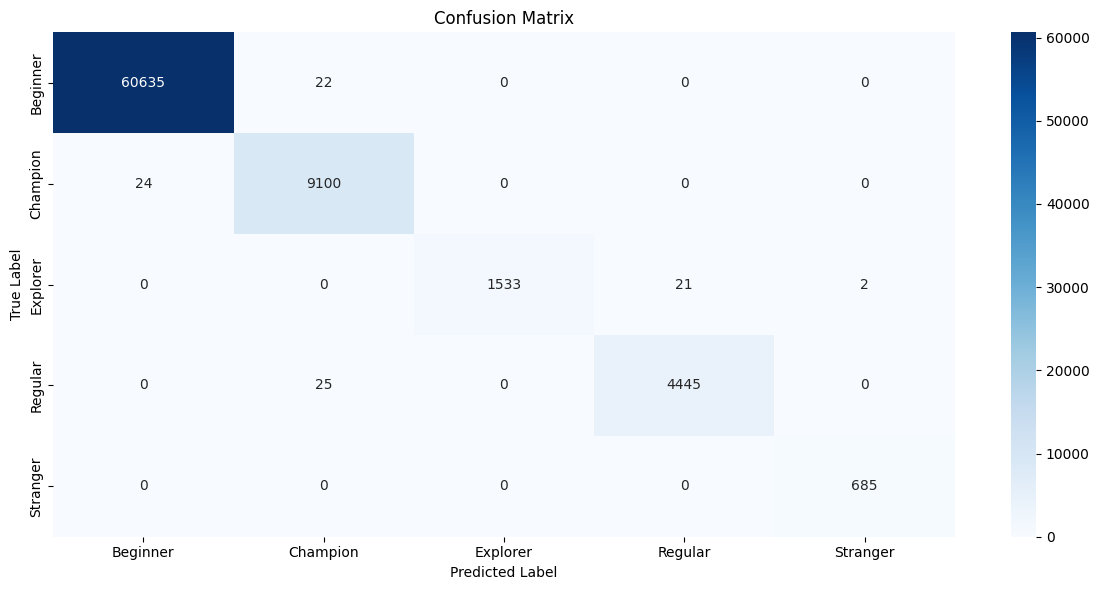

In [39]:
plt.figure(figsize=(12,6))
sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

#Predict New Datasets

In [3]:
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model

In [4]:
import pyarrow.parquet as pq

pq_file = pq.ParquetFile("/content/drive/MyDrive/all_sessions_feb_to_june.parquet")

filtered_chunks = []

start_range = "2025-02-02"
end_range = "2025-03-15"

for i in range(pq_file.num_row_groups):
    chunk = pq_file.read_row_group(i).to_pandas()
    chunk['Date'] = pd.to_datetime(chunk['Date'])
    mask = (chunk['Date'] >= start_range) & (chunk['Date'] <= end_range)
    filtered = chunk.loc[mask]

    if not filtered.empty:
        print(f"Row group {i}: {filtered.shape}")
        filtered_chunks.append(filtered)

final_df = pd.concat(filtered_chunks, ignore_index=True)

print("Final DataFrame shape:", final_df.shape)

Row group 0: (234639, 15)
Row group 1: (231475, 15)
Row group 2: (243667, 15)
Row group 3: (244277, 15)
Row group 4: (253372, 15)
Row group 5: (245984, 15)
Row group 6: (267532, 15)
Row group 7: (245238, 15)
Row group 8: (279361, 15)
Row group 9: (239649, 15)
Row group 10: (279680, 15)
Row group 11: (256548, 15)
Row group 12: (291151, 15)
Row group 13: (335720, 15)
Row group 14: (269019, 15)
Row group 15: (328137, 15)
Row group 16: (294740, 15)
Row group 17: (277179, 15)
Row group 18: (352930, 15)
Row group 19: (300350, 15)
Row group 20: (352420, 15)
Row group 21: (384240, 15)
Row group 22: (182769, 15)
Final DataFrame shape: (6390077, 15)


In [5]:
df_all = final_df.copy()

In [6]:
start_date = pd.to_datetime("2025-02-02")
end_date = pd.to_datetime("2025-06-30")

window_size = timedelta(days=14)

windows = []
current_start = start_date
while current_start < end_date:
    current_end = current_start + window_size
    windows.append((current_start, current_end))
    current_start = current_end

In [7]:
session_model = load_model("session_quality_model.keras")
user_model = load_model("user_flywheel_model.keras")

scaler_sessions = joblib.load("minmax_scaler_sessions.pkl")
scaler_users = joblib.load("minmax_scaler_users.pkl")

label_encoder_sessions = joblib.load("label_encoder_sessions.pkl")
label_encoder_users = joblib.load("label_encoder_users.pkl")

filter_features = ['Impressions','Pageviews','DetailPageviews','Favorites','Shares','Leads','Categories','SubCategories']

output_dir = "predictions_by_window"
os.makedirs(output_dir, exist_ok=True)

for i, (window_start, window_end) in enumerate(windows, 1):
    print(f"Processing Window {i}: {window_start.date()} to {window_end.date()}")

    df_window = df_all[
        (df_all['Date'] >= window_start) &
        (df_all['Date'] <= window_end)
    ].copy()

    if df_window.empty:
        print("  No data in this window. Skipping.")
        continue
    mask = pd.Series(True, index=df_window.index)

    for feature in filter_features:
        lower, upper = df_window[feature].quantile([0.00, 0.999])
        mask &= df_window[feature].between(lower, upper)

    df_window = df_window[mask].copy()

    session_features_raw = df_window[['Impressions', 'Pageviews', 'DetailPageviews','Favorites', 'Shares', 'Leads', 'Categories', 'SubCategories']]
    session_features_scaled = scaler_sessions.transform(session_features_raw)

    session_probs = session_model.predict(session_features_scaled)
    session_preds = session_probs.argmax(axis=1)

    session_label_strings = label_encoder_sessions.inverse_transform(session_preds)

    df_window['session_quality_label'] = session_label_strings

    user_cluster_counts = (
        df_window
        .groupby(['KSL_Member_Id', 'session_quality_label'])
        .size()
        .unstack(fill_value=0)
    )

    user_ratios = (
        user_cluster_counts
        .div(user_cluster_counts.sum(axis=1), axis=0)
        .fillna(0)
        .add_prefix("ratio_")
    )

    user_ratios_scaled = scaler_users.transform(user_ratios)

    user_probs = user_model.predict(user_ratios_scaled)
    user_preds = user_probs.argmax(axis=1)

    user_preds_labels = label_encoder_users.inverse_transform(user_preds)

    user_output = user_ratios.copy()
    user_labels_df = (
        pd.DataFrame({
            'KSL_Member_Id': user_cluster_counts.index,
            'user_flywheel_label': user_preds_labels
        })
    )

    df_labeled = df_window.merge(
        user_labels_df,
        on='KSL_Member_Id',
        how='left'
    )

    trimmed = df_labeled['DDM_Session_Id'].str[:-8]
    df_labeled['timestamp_str'] = trimmed.str[-10:]

    df_labeled['Unix_Timestamp'] = df_labeled['timestamp_str'].astype(int)

    df_labeled['Session_UTC'] = pd.to_datetime(
        df_labeled['Unix_Timestamp'],
        unit='s',
        utc=True
    )
    df_labeled['Session_MST'] = df_labeled['Session_UTC'].dt.tz_convert('America/Denver').dt.strftime('%Y-%m-%d %H:%M:%S')

    df_labeled['Time_Interval'] = i
    df_labeled['Date_Interval'] = (
        f"{window_start.strftime('%m-%d-%Y')}_{window_end.strftime('%m-%d-%Y')}"
    )

    output_path = os.path.join(
        output_dir,
        f"sessions_labeled_{window_start.date()}_{window_end.date()}.parquet"
    )
    df_labeled.to_parquet(output_path, index=False)
    print(f"  Saved labeled sessions to {output_path}")

Processing Window 1: 2025-02-02 to 2025-02-16
68012/68012 ━━━━━━━━━━━━━━━━━━━━ 76s 1ms/step
8796/8796 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
  Saved labeled sessions to predictions_by_window/sessions_labeled_2025-02-02_2025-02-16.parquet
Processing Window 2: 2025-02-16 to 2025-03-02
71210/71210 ━━━━━━━━━━━━━━━━━━━━ 81s 1ms/step
9036/9036 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
  Saved labeled sessions to predictions_by_window/sessions_labeled_2025-02-16_2025-03-02.parquet
Processing Window 3: 2025-03-02 to 2025-03-16
69064/69064 ━━━━━━━━━━━━━━━━━━━━ 82s 1ms/step
8884/8884 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
  Saved labeled sessions to predictions_by_window/sessions_labeled_2025-03-02_2025-03-16.parquet
Processing Window 4: 2025-03-16 to 2025-03-30
  No data in this window. Skipping.
Processing Window 5: 2025-03-30 to 2025-04-13
  No data in this window. Skipping.
Processing Window 6: 2025-04-13 to 2025-04-27
  No data in this window. Skipping.
Processing Window 7: 2025-04-27 to 2025-05-11
  No data

In [10]:
import glob

output_dir = "predictions_by_window"
all_parquets = glob.glob(os.path.join(output_dir, "*.parquet"))

start_range = pd.to_datetime(start_range)
end_range = pd.to_datetime(end_range)

df_all_predictions = pd.concat([
    pd.read_parquet(path) for path in all_parquets
])

df_all_predictions.to_parquet(f"predictions_{start_range.strftime('%m%d%Y')}_{end_range.strftime('%m%d%Y')}.parquet",index=True)